In [163]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [164]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data ready

In [165]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()

X = iris_dataset.data
y = iris_dataset.target
class_names = iris_dataset.target_names
feature_names = iris_dataset.feature_names


In [166]:
df = pd.DataFrame({
    feature_names[0]: X[:, 0],
    feature_names[1]: X[:, 1],
    feature_names[2]: X[:, 2],
    feature_names[3]: X[:, 3],
    "target": class_names[y]
})



df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


## Visualize the data

Text(0, 0.5, 'Petal Width')

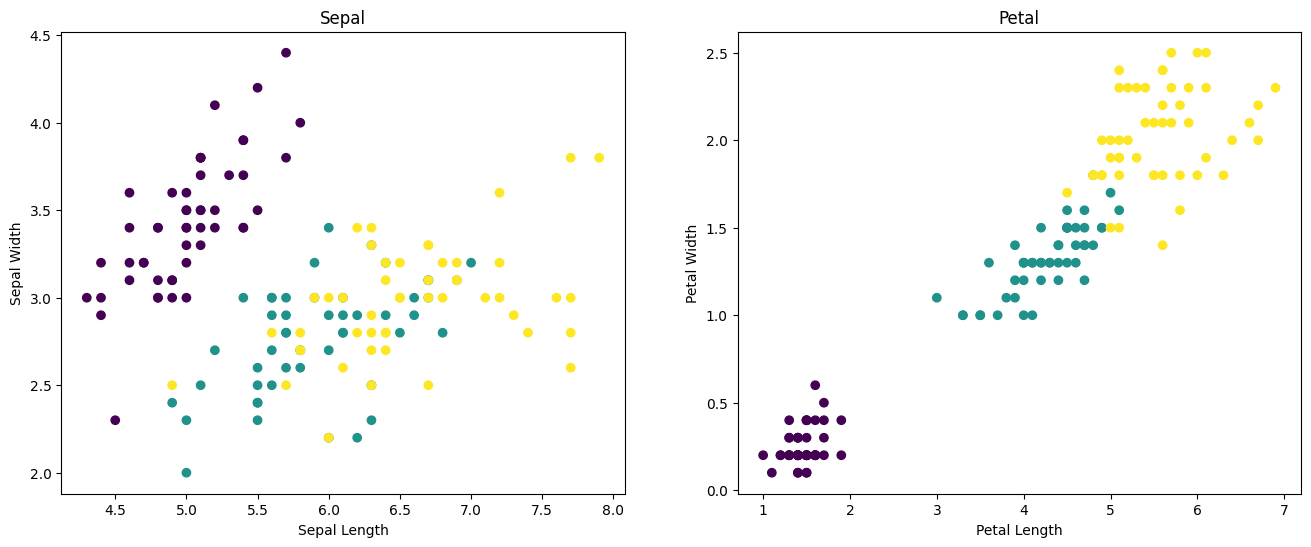

In [167]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)

plt.title("Sepal")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.scatter(df[feature_names[0]], df[feature_names[1]], c=y)

plt.subplot(1, 2, 2)
plt.title("Petal")
plt.scatter(df[feature_names[2]], df[feature_names[3]], c=y)
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")



## Turn data into tensors


In [168]:
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

In [169]:
X[:5], y[:5]

(tensor([[5.1000, 3.5000, 1.4000, 0.2000],
         [4.9000, 3.0000, 1.4000, 0.2000],
         [4.7000, 3.2000, 1.3000, 0.2000],
         [4.6000, 3.1000, 1.5000, 0.2000],
         [5.0000, 3.6000, 1.4000, 0.2000]]),
 tensor([0, 0, 0, 0, 0]))

In [170]:
# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)

(120, 120, 30, 30)

## 2. Build the model

In [171]:
from torch import nn
class MultiLabelClassificationModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(
            in_features=input_shape,
            out_features=hidden_units
        ),
        nn.ReLU(),
        nn.Linear(
            in_features=hidden_units,
            out_features=hidden_units,
        ),
        nn.ReLU(),
        nn.Linear(
            in_features=hidden_units,
            out_features=output_shape
        )
    )

  def forward(self, x):
    return self.layer_stack(x)

In [172]:
model = MultiLabelClassificationModel(
    input_shape=len(feature_names),
    hidden_units=8,
    output_shape=len(class_names)

).to(device)

model

MultiLabelClassificationModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [173]:
#!pip install torchmetrics

In [174]:
# Setup loss, optimizer and accuracy
loss_fn = nn.CrossEntropyLoss()

LEARNING_RATE = 0.1
optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=(len(class_names)))

In [175]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [176]:
# Create a training function
def train_step(
    model, X, y, loss_fn,
    optimizer, accuracy_fn, device):

  loss, acc = 0, 0
  model.train()

  # set data to target device
  X, y = X.to(device), y.to(device)

  # 1. Forward Pass
  y_logits = model(X).squeeze()
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y)
  acc = accuracy_fn(y_preds, y)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  return [loss, acc]






In [177]:
X_train[:5], y_train[:5]

(tensor([[4.6000, 3.2000, 1.4000, 0.2000],
         [6.3000, 2.8000, 5.1000, 1.5000],
         [6.4000, 2.9000, 4.3000, 1.3000],
         [6.2000, 2.2000, 4.5000, 1.5000],
         [7.4000, 2.8000, 6.1000, 1.9000]]),
 tensor([0, 2, 1, 1, 2]))

In [180]:
# create the testing function
def test_step(
    model, X, y, loss_fn,
    accuracy_fn, device):

  loss, acc = 0, 0
  model.eval()

  # set data to target device
  X, y = X.to(device), y.to(device)

  with torch.inference_mode():

    # 1. Forward pass
    test_logits = model(X)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 2. Calculate the loss
    loss = loss_fn(test_logits, y)
    acc = accuracy_fn(test_preds, y)

  return [loss, acc]

In [183]:
from tqdm.auto import tqdm

epochs = 1000

for epoch in tqdm(range(epochs)):
  train = train_step(
      model, X_train, y_train, loss_fn,
      optimizer, accuracy_fn, device
  )

  test = test_step(
      model, X_test, y_test, loss_fn,
      accuracy_fn, device
  )

  if epoch % 200 == 0:
    print(f"Train loss: {train[0]:.5f} Train acc: {train[1]:.2f}% | Test loss: {test[0]:.5f} Test acc: {test[1]:.2f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss: 0.45019 Train acc: 0.75% | Test loss: 0.21323 Test acc: 0.93%
Train loss: 0.19536 Train acc: 0.92% | Test loss: 0.13200 Test acc: 0.93%
Train loss: 0.12578 Train acc: 0.95% | Test loss: 0.09873 Test acc: 0.93%
Train loss: 0.04630 Train acc: 0.98% | Test loss: 0.10525 Test acc: 0.97%
Train loss: 0.09184 Train acc: 0.95% | Test loss: 0.17554 Test acc: 0.97%


In [364]:
idx = 15
test = X_test[idx]
model.eval()

with torch.inference_mode():
  test = torch.unsqueeze(test, dim=0).to(device)
  pred_logit = model(test)
  pred_probs = torch.softmax(pred_logit, dim=1)
  print(pred_probs)

pred = pred_probs.argmax(dim=1).item()
correct = y_test[idx].item()
print(f"Prediction: {pred} - {class_names[pred]}")
print(f"Correct: {correct} - {class_names[correct]}")

tensor([[1.0910e-09, 2.9348e-03, 9.9707e-01]])
Prediction: 2 - virginica
Correct: 2 - virginica


In [372]:
def make_predictions(model, data, device):
  model.to(device)
  predictions = []
  model.eval()

  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit, dim=1).argmax(dim=1).item()
      predictions.append(pred_prob)

  return predictions



In [419]:
import random
test_samples = []
test_labels = []

test_data = torch.cat((X_test, y_test.unsqueeze(dim=1)), 1)
random_test = random.choices(test_data, k=5)
for sample in random_test:
  test_samples.append(sample[:4])
  test_labels.append(sample[4].item())

test_samples


[tensor([4.3000, 3.0000, 1.1000, 0.1000]),
 tensor([5.7000, 2.8000, 4.1000, 1.3000]),
 tensor([6.5000, 3.0000, 5.8000, 2.2000]),
 tensor([6.1000, 3.0000, 4.6000, 1.4000]),
 tensor([5.8000, 2.8000, 5.1000, 2.4000])]

In [420]:
predictions = make_predictions(model, test_samples, device)
print(f"Predictions: {predictions} | Correct: {list(map(int, test_labels))}")

num_correct = 0
for i in range(len(predictions)):
  if predictions[i] == int(test_labels[i]):
    num_correct += 1

print(f"{num_correct}/{len(predictions)} got correct!")

Predictions: [0, 1, 2, 1, 2] | Correct: [0, 1, 2, 1, 2]
5/5 got correct!
